
The goal of this work is to determine whether there is a match between two products. We have data on products available in the market and products offered by merchants. Therefore, our task involves binary classification, where 1 indicates a match, and 0 signifies the absence of a match. Metrics should be F1 score, as set by the hosts of the workshop.

This workshop is run as a contest on the Kaggle platform, leading to several particularities:

- Handling tails poses a challenge because the test data must be processed similarly to the train data. However, in the case of dropping tails, they should be dropped in the test data as well. On Kaggle, the test data must contain the same number of rows as in a given.
- Another consideration is the size of the dataset. It may be challenging to scale the data, and models that rely on scaled data, such as SVM and neural networks, might be prohibited.

I'll start with tree-based models like CatBoost, Light GBM, and those using gradient boosting, considering the discussed factors in machine learning. I will perform hyperparameter tuning using the Optuna framework, taking into account the dataset size and other considerations.

If the outcome is unsatisfactory, I will turn to pretrained neural networks like Siamese. My observation is fitting models in batches is straightforward and won't lead to memory limit exceedances. However, scaling could be a real challenge with large datasets, especially considering I rely on open sources like Google Colab and Kaggle. 

I won't use cross-validation; instead, I'll split the data into train and validation sets.

**Data description**

Columns:

1. `offer_depersonalised` and `goods_depersonalised`: Identifiers for the offer and the corresponding product, respectively.
2. `sum_length`: The total length of the pair of names and attributes in characters.
3. `attrs+title_score`: Probability of a match from the rescoring model.
4. `offer_price` and `item_price`: The price of the offer and the respective product.
5. `goods_category_id`: The category of the product.
6. `id`: Identifier for the pair `offer_depersonalised + $ + goods_depersonalised`.
7. `target` (only in train.csv): Class label (0 - no match, 1 - match).


Embeddings:

- `goods_image_vectors` and `offer_image_vectors`: Contain files with vectors of images (`embed_deperson.npy`) and their identifiers (`items_deperson.npy`) for products and offers, respectively. Objects in the files correspond 1 to 1.

- `goods_title_vectors` and `offer_title_vectors`: Contain files with vectors of titles+attributes (`embed_deperson.npy`) and their identifiers (`items_deperson.npy`) for products and offers, respectively. Objects in the files correspond 1 to 1.

Our data is represented as train and test datasets in CSV files. Embeddings are stored in NPY format. The data's size may pose challenges related to memory constraints and limits.

### Imports and data loading

In [1]:
# general libraries
import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm
tqdm.pandas()

# visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.size'] = 16

import gc
# ignore warnings
import warnings
warnings.filterwarnings(action='ignore', 
                        category = DeprecationWarning)
# mashine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA

!pip install catboost -q
!pip install --upgrade catboost -q
import catboost
from catboost import  Pool, CatBoostClassifier
import optuna

# Fix the randomness parameter for the generators
SEED = 21
np.random.seed(SEED)

# Check the state of the graphics card
!nvidia-smi

from sklearn.model_selection import cross_val_score
from catboost import Pool
from sklearn.metrics import mean_absolute_error

/tmp/ipykernel_34/534578901.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Tue Apr  2 10:45:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# load data in csv format
train = pd.read_csv('/kaggle/input/samokat-tech/train.csv')
train.head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,37,0.027267,1070,NaN,14.0,0,295140$1396793
1,65291,1396586,38,0.050415,698,NaN,14.0,0,65291$1396586
2,39232,1396244,38,0.087280,837,NaN,14.0,0,39232$1396244
3,39232,1396513,38,0.087280,837,NaN,14.0,0,39232$1396513
4,65052,1396237,38,0.079773,1085,NaN,14.0,0,65052$1396237


Data has been loaded.

In [3]:
# load test data in csv format
test_data = pd.read_csv('/kaggle/input/samokat-tech/test.csv')
test_data.shape

(363835, 8)

## Preprocessing and analysis

Preprocessing will be carried out according to the following scenario:
- Evaluation
- Analysis of data types and, if necessary, conversion to the required data type
- Analysis of missing values and consideration of possible imputation
- Analysis of anomalous and rare values and consideration of possible replacement/deletion


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518441 entries, 0 to 2518440
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   offer_depersanalised  int64  
 1   goods_depersanalised  int64  
 2   sum_length            int64  
 3   attrs+title_score     float64
 4   offer_price           int64  
 5   goods_price           float64
 6   goods_category_id     float64
 7   target                int64  
 8   id                    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 172.9+ MB


- The `offer_price` column is of type int64, while `goods_price` is float64. Confirm if this difference in data types is intentional.

- The `id` column is of object type. Depending on its content, I will encode it into a numerical format for model training.

- The memory usage is relatively high (172.9 MB).

In [5]:
# check for unique values
print(f''' 
Number of unique offers is: {train['offer_depersanalised'].nunique()}

Number of unique goods is: {train['goods_depersanalised'].nunique()}'''
)

 
Number of unique offers is: 500000

Number of unique goods is: 1592607


It's possible that a single offer corresponds to more than one item in the dataset.

In [6]:
# Examine the unique goods grouped by offer ID
train.groupby('offer_depersanalised').agg(goods_unique = ('goods_depersanalised', 'count'),
                                         goods_category_unique = (('goods_category_id', 'nunique')))

,goods_unique,goods_category_unique
offer_depersanalised,,
0,5,2
3,5,2
4,5,4
5,5,4
8,5,1
...,...,...
572761,5,4
572762,5,2
572763,5,3


We observe that each offer can be associated with multiple goods (which is appropriate for product matching tasks). However, there is also the possibility of an offer being associated with multiple product categories, which might pose challenges and ambiguities. This consideration is noteworthy, especially given that each item on the marketplace is strictly related to a single category.

In [7]:
# check for duplicates
train['id'].nunique()

2500000

The number of unique IDs is less than the total entries in the dataset: there are 2,500,000 unique IDs compared to 2,518,440 total entries.

These are not considered duplicates, as the same item may be used for matching with different offers. We'll specifically examine duplicates in the 'id' column since pairs of goods in our data should be unique, and it doesn't make sense to have multiple identical pairs in the dataset."

In [8]:
# Let's check for duplicates based on the goods_depersanalised column. 
train['goods_depersanalised'].duplicated().sum()

925834

In [9]:
# let's have a look to data with duplicated
train[train['id'].duplicated(keep = False)].head(10)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
652,357107,851154,56,0.000048,7579,34952.0,82.0,0,357107$851154
653,357107,851154,56,0.000048,7579,34952.0,81.0,0,357107$851154
4850,19880,790671,67,0.000038,4658,2960.0,83.0,0,19880$790671
4851,19880,790671,67,0.000038,4658,2960.0,82.0,0,19880$790671
5337,21236,790671,67,0.076294,3037,2960.0,83.0,0,21236$790671
5338,21236,790671,67,0.076294,3037,2960.0,82.0,0,21236$790671
10889,314195,790669,74,0.000041,1607,1833.0,83.0,0,314195$790669
10890,314195,790669,74,0.000041,1607,1833.0,82.0,0,314195$790669
12158,314243,790669,75,0.000116,1127,1833.0,83.0,0,314243$790669
12159,314243,790669,75,0.000116,1127,1833.0,82.0,0,314243$790669


In [10]:
# drop duplicated data
train.drop_duplicates(subset ='id', 
                      keep = 'first', 
                      inplace = True, 
                      ignore_index = False)

I notice that they differ in the 'goods_category_id' feature, which should be unique for each item. To eliminate ambiguity in matching, I'll remove these entries.

In [11]:
# check
train['id'].duplicated(keep = False).sum()

0

In [12]:
#  Examine the unique categories grouped by goods 
# to ensure they are unique for each item in the market
goods_categories = train.groupby('goods_depersanalised')\
                            .agg(categories_unique = ('goods_category_id', 'nunique'))

goods_categories.loc[goods_categories['categories_unique'] >1]

,categories_unique
goods_depersanalised,


### Missing values

In [13]:
# initialize a function to visualize missing values which will show only columns with missing vals in it as b horizontal bar
def pass_value_barh(df):
    try:(
        (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh',
                  figsize = (19,6),
                  rot = -0,
                  legend = False,
                  fontsize = 16,
                  xticks=[i/10 for i in range(0, 1000, 50)],
                  color='skyblue')
            .set_title('Number of missing values' + "\n", fontsize = 22, color = 'Black')
        );
    except:
        print('No missing values')

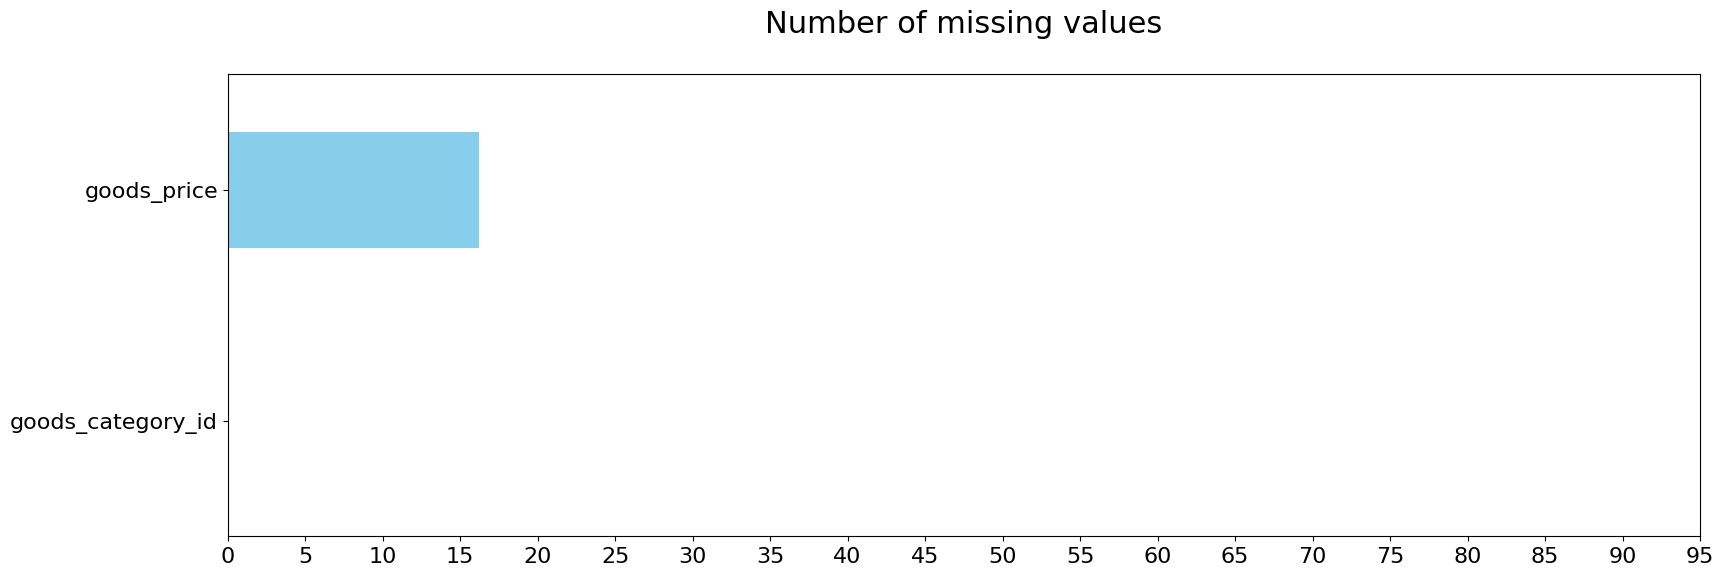

In [14]:
pass_value_barh(train)

Let's try to find the reason for the appereance of these Nans 

#### goods_category_id

In [15]:
# examine unuque cats of goods
train['goods_category_id'].unique()

array([1.40000000e+01, 2.00000000e+00, 8.10000000e+01, 8.00000000e+00,
       1.90000000e+01, 3.00000000e+00, 1.10000000e+01, 2.10000000e+01,
       5.00000000e+00, 6.00000000e+00, 8.30000000e+01, 8.20000000e+01,
       4.00000000e+00, 7.00000000e+00, 2.46368463e+15, 1.30000000e+01,
                  nan, 1.70000000e+01, 9.00000000e+00, 6.90000000e+01,
       1.80000000e+01])

All categories appear to be in scientific notation, likely due to category '2463684633817211'. Let's correct this issue by temporarily replacing it with 10. However, it is mandatory to revert this change after completing the exploratory data analysis (EDA), so the owner of the data would be able to distinguish this category again.

In [16]:
# replace cat which inconvinient with value 10
train.loc[train['goods_category_id'] == 2463684633817211.0, 'goods_category_id'] = 10

train['goods_category_id'].unique()

array([14.,  2., 81.,  8., 19.,  3., 11., 21.,  5.,  6., 83., 82.,  4.,
        7., 10., 13., nan, 17.,  9., 69., 18.])

In [17]:
# replace cat which inconvinient with value 10 in test data as well
test_data.loc[test_data['goods_category_id'] == 2463684633817211.0, 'goods_category_id'] = 10

test_data['goods_category_id'].unique()

array([14.,  2.,  4.,  6., 19.,  8., 11.,  3., 21., 81., 83.,  5., 82.,
       10.,  7.,  9., nan, 17., 69., 13., 18.])

In [18]:
# estimate the mean and median value of the price grouped by category
price_grouped = train.groupby(['goods_category_id']).agg(mean_price = ('goods_price', 'mean'),
                                         median_price = ('goods_price', 'median'))
price_grouped


,mean_price,median_price
goods_category_id,,
2.0,12195.305063,3490.0
3.0,1874.055396,784.0
4.0,175894.622505,1395.0
5.0,10749.470963,1965.0
6.0,279897.305802,2458.0
7.0,911.207605,522.0
8.0,27467.064628,13830.5
9.0,2387.563446,932.0
10.0,4595.877209,1090.0


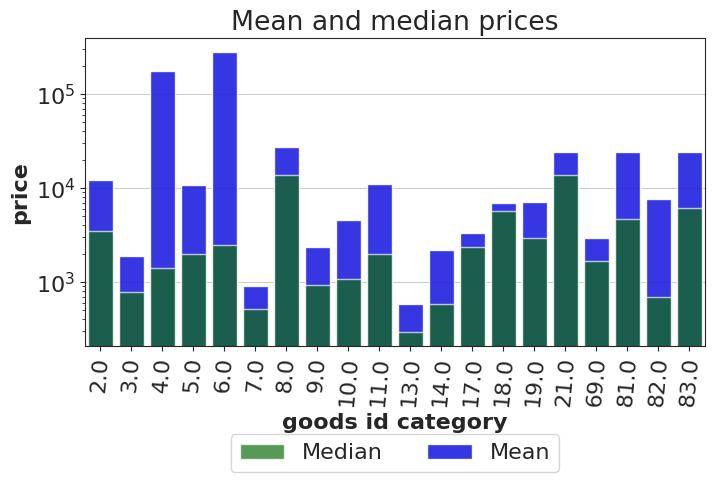

In [19]:
# compare median and mean values by plotting them on one graph
plt.figure(figsize=(8, 4))
sns.set_style('ticks', {'axes.grid': True})

# Create a bar chart for mean values
mean_plot = sns.barplot(x = price_grouped.index,
                            y = price_grouped['mean_price'],
                            color = 'blue',
                            alpha = 0.9,
                            label = 'Mean')

# Create a bar chart for median values
median_plot = sns.barplot(x = price_grouped.index,
                            y = price_grouped['median_price'],
                            color = 'green',
                            alpha = 0.7,
                            label = 'Median')
# set labels
plt.xlabel('goods id category', fontweight='bold')

plt.ylabel('price', fontweight='bold')

plt.title(f'Mean and median prices')

plt.xticks(rotation = 85)

plt.yscale('log') # make values of different scales visible

# customizing a legend
handles, labels = plt.gca().get_legend_handles_labels()

handles.reverse()
labels.reverse()
plt.legend(handles,
            labels,
            bbox_to_anchor=(0.5, -0.25),
               loc='upper center',
               ncol=2)

plt.show()

Observe that for some categories, the mean and median prices differ, indicating that it would be incorrect to fill missing values of price with either the median or mean prices.

We cannot simply drop all missing values altogether. Upon inspection, we notice a minimal amount of missing values in one category (goods_category_id 892), while the 'price' column has 407,287 missing values. Primarily, missing values are prevalent in the 'goods_price' column. To address this, we can fill missing values in the 'goods_price' column with the average price of the respective goods category and drop missing values in the 'goods_category_id' column.

In [20]:
# look at the data where there are missing values
train.loc[train['goods_price'].isna() | train['goods_category_id'].isna()].head(10)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,37,0.027267,1070,NaN,14.0,0,295140$1396793
1,65291,1396586,38,0.050415,698,NaN,14.0,0,65291$1396586
2,39232,1396244,38,0.087280,837,NaN,14.0,0,39232$1396244
3,39232,1396513,38,0.087280,837,NaN,14.0,0,39232$1396513
4,65052,1396237,38,0.079773,1085,NaN,14.0,0,65052$1396237
5,90396,1396237,38,0.079773,350,NaN,14.0,0,90396$1396237
6,373848,1396822,39,0.000035,1391,NaN,14.0,0,373848$1396822
7,295140,1396237,39,0.065979,1070,NaN,14.0,0,295140$1396237
9,64799,1396335,40,0.047699,348,NaN,14.0,0,64799$1396335
10,379158,1396822,40,0.020340,856,NaN,14.0,0,379158$1396822


In [ ]:
# attempt to identify missing cats by grouping the data on goods
train.groupby('goods_depersanalised')\
                                        .agg(categories = ('goods_category_id', 'unique'),
                                             num_categories = ('goods_category_id', 'nunique'))\
                                        .sort_values(by = 'num_categories', ascending = False)

Since all objects in 'goods_depersonalised' refer to a single category, it becomes challenging to identify the associated category for each good. Therefore, I need to fill those values with something synthetic.

### Filling missing values using CatBoost

I use columns without missing values as features, while columns with NaNs become the target variables. This approach allows leveraging the CatBoost algorithm to predict missing values based on the other features in the dataset 

I will make a test data from data with missing vals in it and afterwards fill it with those values. As a target i'll take goods_price and goods_category_id. But i have to train my catboost model on a data without target column as well because my test sample does not have it, and i need to fill test data as well.

#### goods_price

In [ ]:
train_goods_price = train.dropna(subset=['goods_price', 'goods_category_id']).copy()
test_goods_price = train[train['goods_price'].isna()].copy()

# make a train features and target
X = train_goods_price.drop(['goods_price', 'target'], axis = 1).columns.to_list()
y = 'goods_price'

print(f'''
Size of train data for filling goods_price feature: {train_goods_price.shape}

Size of test data for filling goods_price feature: {test_goods_price.shape}
''')

In [ ]:
train_goods_price.isna().sum()

In [ ]:
train_goods_price['goods_price'].quantile([.9998])

In [ ]:
# replace outliers 
train_goods_price = train_goods_price.loc[train_goods_price['goods_price'] < 500000]

In [ ]:
train_goods_price, valid_goods_price = train_test_split(train_goods_price, 
                                                        test_size = 0.25,
                                                        random_state = SEED)
print(f'''
Train sample size:{train_goods_price.shape} 

valid sample size:{valid_goods_price.shape}

test sample size: {test_goods_price.shape}''')

In [ ]:
# create a pool instance
train_pool = Pool(data = train_goods_price[X],
                  label = train_goods_price[y],
                  cat_features = ['id'])

valid_pool = Pool(data = valid_goods_price[X],
                  label = valid_goods_price[y],
                  cat_features = ['id'])
test_pool = Pool(data = test_goods_price[X], 
                 cat_features = ['id'])

print(f'''
train_pool shape {train_pool.shape}

valid_pool shape {valid_pool.shape}

test_pool shape {test_pool.shape}
''')

In [ ]:
# initiate a model
filler = catboost.CatBoostRegressor(random_seed=SEED,
                                     verbose=100, 
                                     task_type="GPU")

In [ ]:
#train
filler.fit(train_pool, eval_set=(valid_pool))

predicted_price = filler.predict(valid_goods_price[X])

mae_score = mean_absolute_error(valid_goods_price[y], predicted_price)
print(mae_score)

This result can be considered satisfying, considering that we attempted to find missing prices. The average error of 4592 is quite good. Therefore, let's fill the missing values in our data with the prices predicted by our model.

In [ ]:
predicted_price = filler.predict(test_goods_price[X])

print(f'''
The shape of filled test sample is {predicted_price.shape}

The shape of train data with missing vals in goods_price col is {train.loc[train['goods_price'].isna(), 'goods_price'].shape}''')

They are the same so we can fill our data

In [ ]:
train.loc[train['goods_price'].isna(), 'goods_price'] = predicted_price
# check the result
pass_value_barh(train)

It worked. Lets assess the distribution on a new data after filling with synthetic data

In [ ]:
# Assess the distribution of values so that after filling, we can evaluate the change in the distribution
train[['goods_price']].describe().transpose()

previous distribution and current are the same, so we did great

![image.png](attachment:b847cae1-4db5-44e8-8be6-6cfd66f3c6ab.png)



#### goods_category_id

This task is already a classification task, so we slightly change our model and wont to split on val and train, due to a tiny amount of data to fill

In [ ]:
train['goods_category_id'].unique()

In [ ]:
# remove Nan in order to plot distribution
unique_categories = ([14.,  2., 81.,  8., 19.,  3., 11., 21.,  5.,  6., 83., 82.,  4., 7., 10., 13., 17.,  9., 69., 18.]) 

#Plot histogram
plt.figure(figsize=(21, 4))
train.loc[train['goods_category_id'].notna(), 'goods_category_id'].hist(bins = len(unique_categories), 
                                                   color='skyblue', 
                                                   edgecolor = 'black', 
                                                   alpha = 0.7)
plt.xlabel('Category ID')
plt.ylabel('Frequency')
plt.title('Distribution of goods category ID')
plt.xticks(unique_categories, rotation = 75) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
test_goods_category_id = train.loc[train['goods_category_id'].isna()].copy()
train_goods_category_id = train.loc[train['goods_category_id'].notna()].copy()

# make a train features and target
X = train_goods_price.drop(['goods_category_id', 'target'], axis = 1).columns.to_list()
y = 'goods_category_id'

print(f'''
Size of train data for filling goods_price feature: {train_goods_category_id.shape}

Size of test data for filling goods_price feature: {test_goods_category_id.shape}
''')

In [36]:
filler_id = catboost.CatBoostClassifier(random_seed = SEED,
                                        verbose = 100, 
                                        task_type = 'GPU',
                                        loss_function = 'MultiClass')

train_id_pool = Pool(data = train_goods_category_id[X],
                     label = train_goods_category_id[y],
                     cat_features = ['id'])

test_id_pool = Pool(data = test_goods_category_id[X], 
                    cat_features = ['id'])

filler_id.fit(train_id_pool)

100:	learn: 1.3817890	total: 16.1s	remaining: 2m 23s
200:	learn: 1.2393538	total: 31.9s	remaining: 2m 6s
300:	learn: 1.1637009	total: 47.9s	remaining: 1m 51s
400:	learn: 1.1167064	total: 1m 3s	remaining: 1m 35s
500:	learn: 1.0823643	total: 1m 20s	remaining: 1m 19s
600:	learn: 1.0550882	total: 1m 36s	remaining: 1m 3s
700:	learn: 1.0330188	total: 1m 52s	remaining: 48s
800:	learn: 1.0144326	total: 2m 8s	remaining: 31.9s
900:	learn: 0.9984833	total: 2m 24s	remaining: 15.9s
999:	learn: 0.9844350	total: 2m 41s	remaining: 0us


In [37]:
train_id_predicted = filler_id.predict(test_id_pool)

print(f'''
Shape of training data with missing vals in goods_category_id {train.loc[train['goods_category_id'].isna(), 'goods_category_id'].shape}

Shape of predicted data  {train_id_predicted.shape}''')


Shape of training data with missing vals in goods_category_id (833,)

Shape of predicted data  (833, 1)


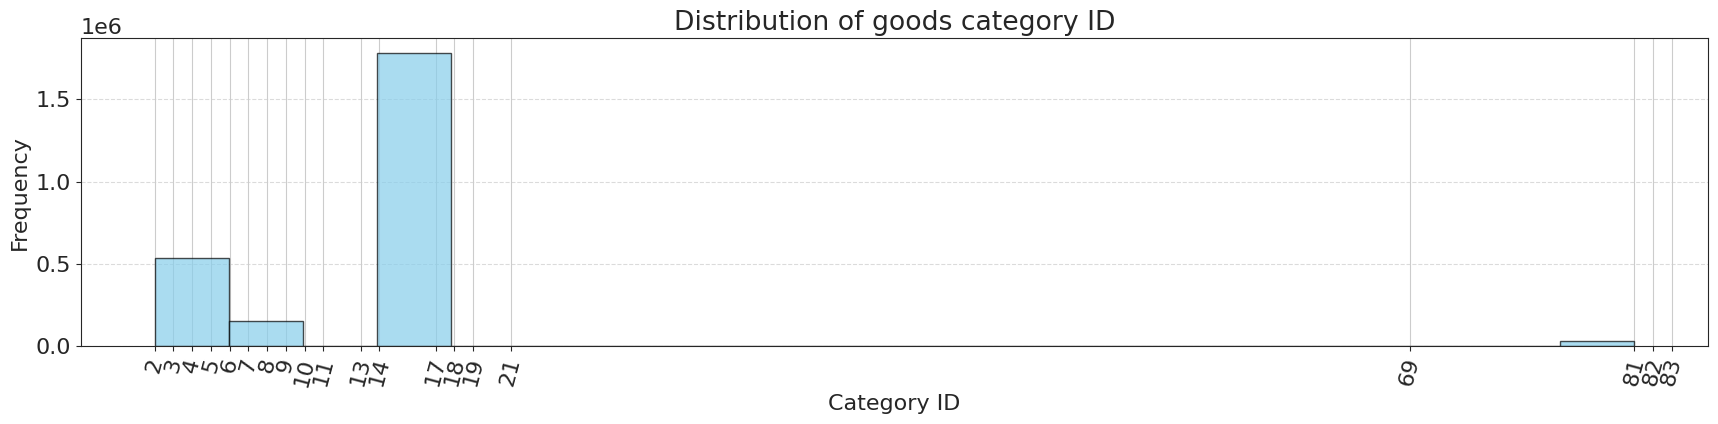

In [38]:
train.loc[train['goods_category_id'].isna(), 'goods_category_id'] = train_id_predicted

# access the distribution after filling
unique_categories = ([14.,  2., 81.,  8., 19.,  3., 11., 21.,  5.,  6., 83., 82.,  4., 7., 10., 13., 17.,  9., 69., 18.]) 

#Plot histogram
plt.figure(figsize=(21, 4))
train.loc[train['goods_category_id'], 'goods_category_id'].hist(bins = len(unique_categories), 
                                                   color='skyblue', 
                                                   edgecolor = 'black', 
                                                   alpha = 0.7)
plt.xlabel('Category ID')
plt.ylabel('Frequency')
plt.title('Distribution of goods category ID')
plt.xticks(unique_categories, rotation = 75) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

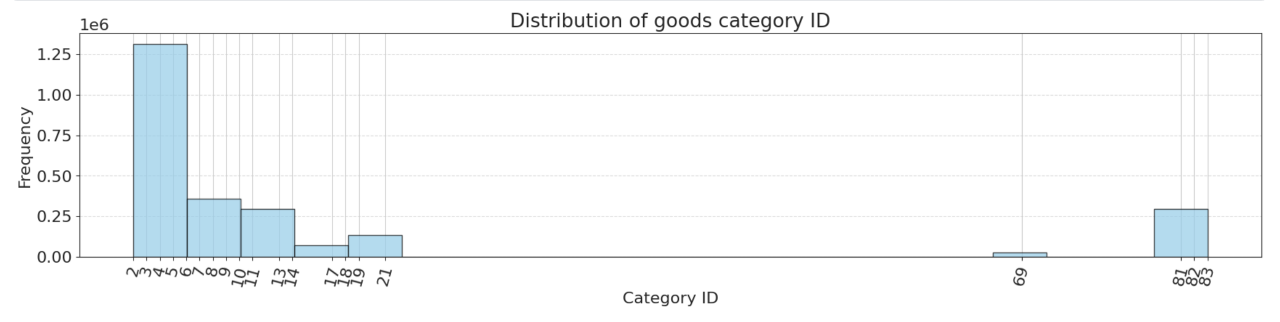

It does not looks the same, but i belive it.

No missing values


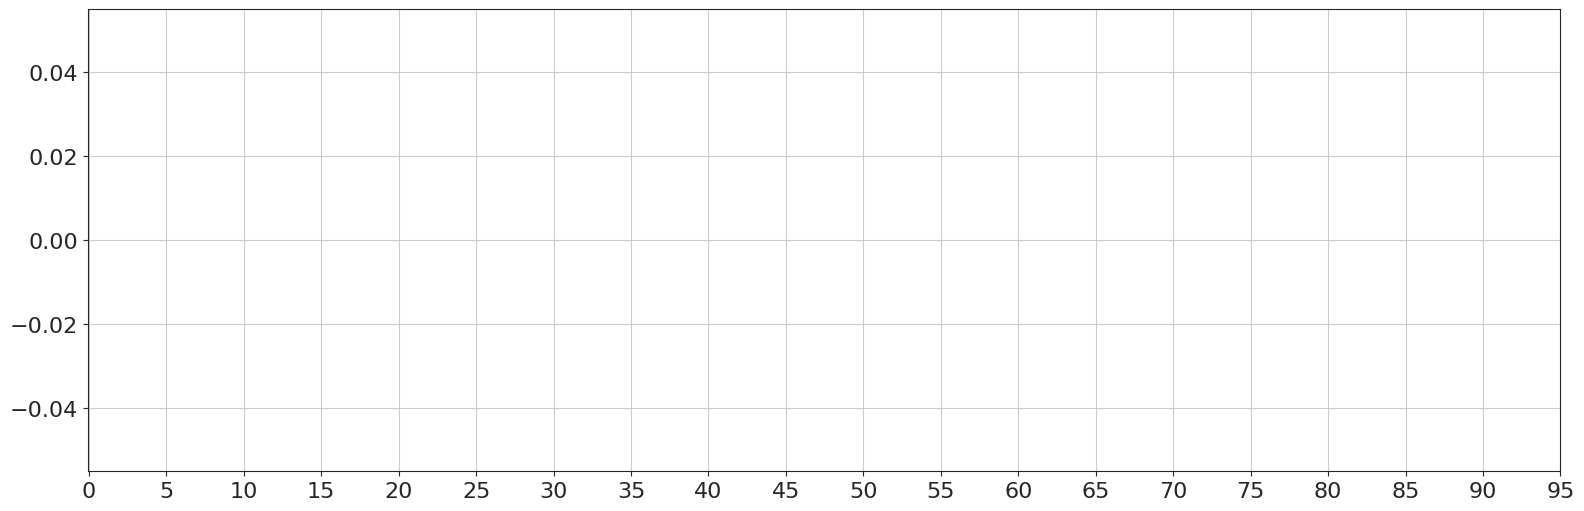

In [39]:
pass_value_barh(train)

Preprocess missing values in test data in the same way

### Filling NaN in test data

#### goods price

In [40]:
# make test data the same way 
# drop rows with missing vals 
test_goods_price = test_data.dropna(subset=['goods_category_id']).copy()

# leave only with NaNs in goods_price
test_goods_price_X = test_goods_price.loc[test_goods_price['goods_price'].isna()]

print(f'''
Shape of features of full origin test data is {test_data.shape}

Shape of test data with NaNs (target) is {test_goods_price_X.shape}
''')


Shape of features of full origin test data is (363835, 8)

Shape of test data with NaNs (target) is (58917, 8)



In [41]:
test_price_pool = Pool(data = test_goods_price_X,
                 cat_features = ['id'])

test_price_predicted = filler.predict(test_price_pool)

print(f'''
Shape of test data with NaNs (target) is {test_data.loc[(test_data['goods_price'].isna()) & (test_data['goods_category_id'].notna()), 'goods_price'].shape}

Shape predicted values {test_price_predicted.shape}
''')


Shape of test data with NaNs (target) is (58917,)

Shape predicted values (58917,)



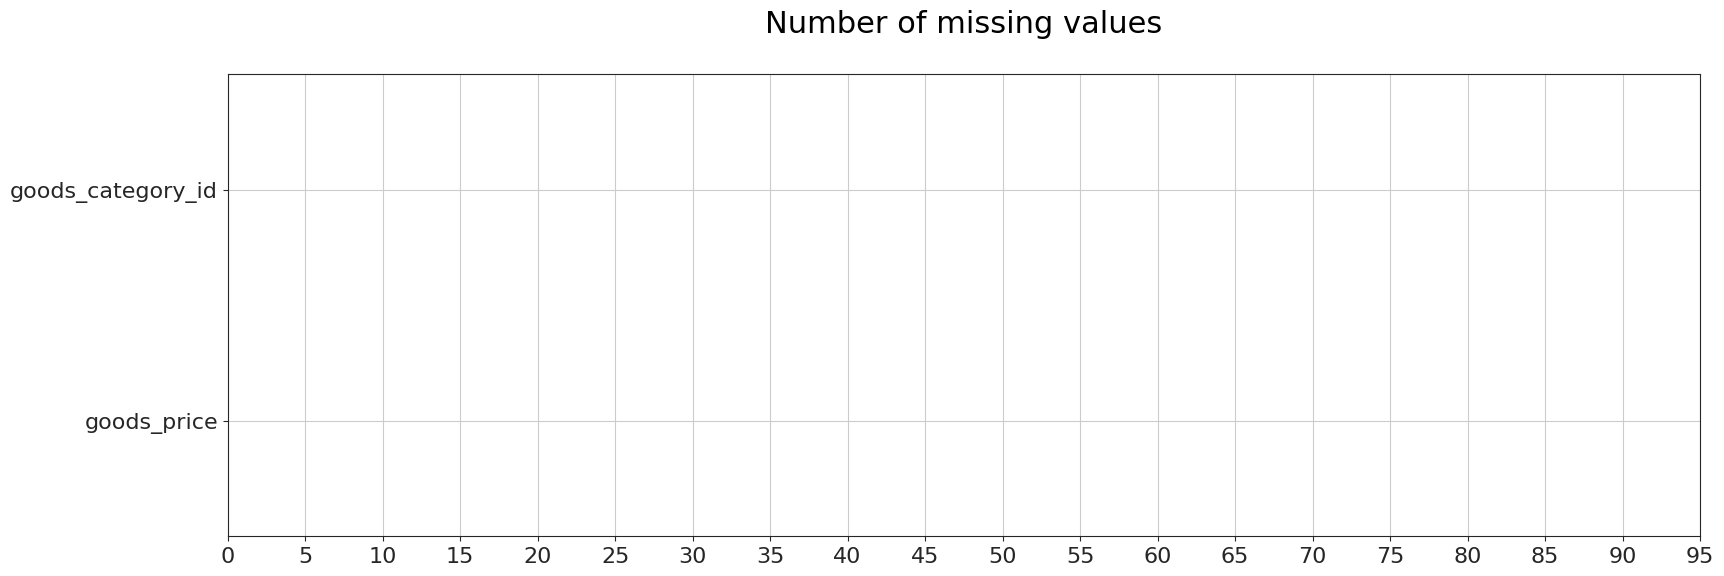

In [43]:
# fill the values
test_data.loc[(test_data['goods_price'].isna()) & (test_data['goods_category_id'].notna()), 'goods_price'] = test_price_predicted
pass_value_barh(test_data)

In [55]:
median_price_map = train.groupby(['goods_category_id'])['goods_price'].median()
median_price_map

goods_category_id
2.0      4380.000000
3.0       868.000000
4.0      2034.000000
5.0      2800.000000
6.0      3090.000000
7.0       550.789974
8.0     13783.212629
9.0      1079.282715
10.0     1290.000000
11.0     4200.000000
13.0      373.000000
14.0      618.000000
17.0     2511.000000
18.0     6250.000000
19.0     3412.000000
21.0    14920.000000
69.0     1720.236691
81.0     4890.000000
82.0      688.000000
83.0     6520.000000
Name: goods_price, dtype: float64

In [56]:
test_data.loc[test_data['goods_price'].isna(), 'goods_price'] = test_data.loc[test_data['goods_price'].isna(), 'goods_category_id'] \
                                                    .map(median_price_map)
test_data['goods_price'].isna().sum()

0

#### goods_category_id 

In [57]:
test_data['goods_category_id'].isna().sum()

0

In [45]:
test_goods_id_X = test_data.loc[test_data['goods_category_id'].isna()]

print(f'''
Shape of features of full origin test data with NaNs in goods_id and not Nan in goods price is \
{test_data.loc[test_data['goods_category_id'].isna(), 'goods_category_id'].shape}

Shape of test data with NaNs (target) is {test_goods_id_X.shape}
''')


Shape of features of full origin test data with NaNs in goods_id and not Nan in goods price is (131,)

Shape of test data with NaNs (target) is (131, 8)



In [46]:
test_goods_id_pool = Pool(data = test_goods_id_X,
                          cat_features = ['id'])

test_goods_id_predicted = filler_id.predict(test_goods_id_pool)

print(f'''
Shape of features of full origin test data with NaNs in goods_id and not Nan in goods price is \
{test_data.loc[test_data['goods_category_id'].isna(), 'goods_category_id'].shape}

Shape predicted values {test_goods_id_predicted.shape}
''')


Shape of features of full origin test data with NaNs in goods_id and not Nan in goods price is (131,)

Shape predicted values (131, 1)



No missing values


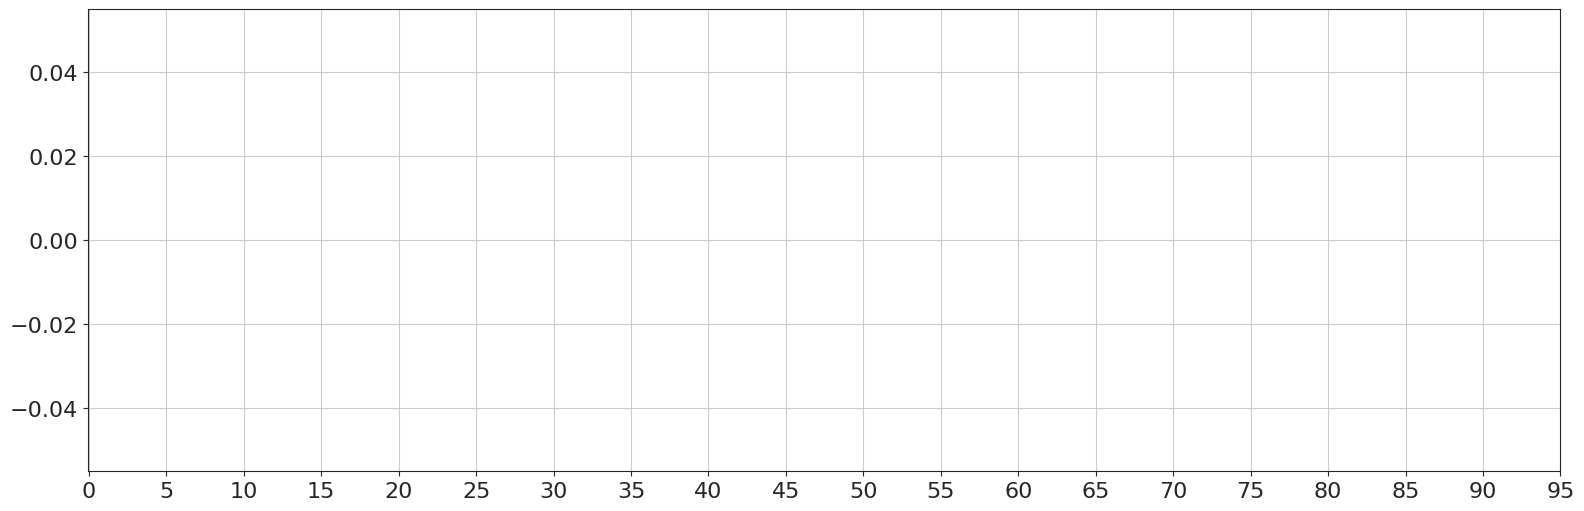

In [59]:
#test_data.loc[test_data['goods_category_id'].isna(), 'goods_category_id'] = test_goods_id_predicted
# check
pass_value_barh(test_data)

### Outliers and rare values

Since we can't drop anomalous values in the test data, I will examine it first. Only after examining the test data for such values will I decide what action to take, if needed.

,0.0050,0.9800,0.9900,0.9998
goods_price,124.0,75090.0,110499.01,449100.0


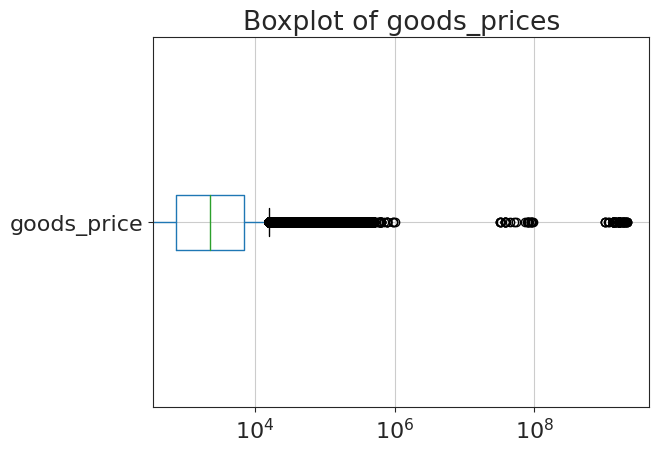

In [70]:
# plot at boxplot
train[['goods_price']].boxplot(vert = False)
plt.title('Boxplot of goods_prices')
plt.xscale('log')

# look at quantiles of values
train[['goods_price']].quantile([.005, .98, .99, .9998]).transpose()

,0.0050,0.9800,0.9900,0.9998
goods_price,121.0,74853.84,109822.26,438688.9636


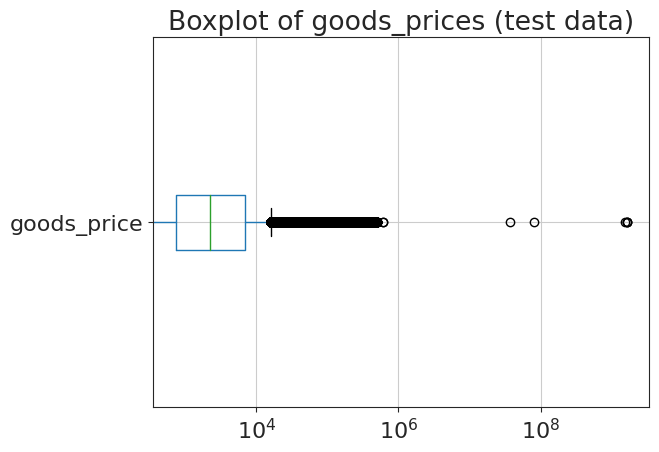

In [72]:
# plot at boxplot test data
test_data[['goods_price']].boxplot(vert = False)
plt.title('Boxplot of goods_prices (test data)')
plt.xscale('log')# look at quantiles of values

test_data[['goods_price']].quantile([.005, .98, .99, .9998]).transpose()

In [74]:
# we cant drop outliers so just replace them with the value in 0.9998 quantile
train.loc[train['goods_price'] > 449100.0, 'goods_price'] = 449100.0
test_data.loc[test_data['goods_price'] > 438688.9636, 'goods_price'] = 438688.9636

,0.0050,0.9800,0.9900,0.9998
goods_price,121.0,74853.84,109822.26,438595.441912


,0.0050,0.9800,0.9900,0.9998
goods_price,121.0,74853.84,109822.26,438595.441912


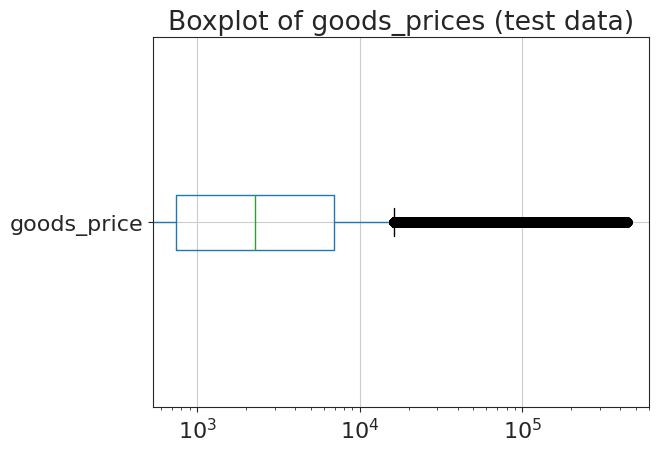

In [75]:
# plot at boxplot test data
test_data[['goods_price']].boxplot(vert = False)
plt.title('Boxplot of goods_prices (test data)')
plt.xscale('log')# look at quantiles of values

test_data[['goods_price']].quantile([.005, .98, .99, .9998]).transpose()

,0.0050,0.9800,0.9900,0.9998
goods_price,124.0,75090.0,110499.01,449100.0


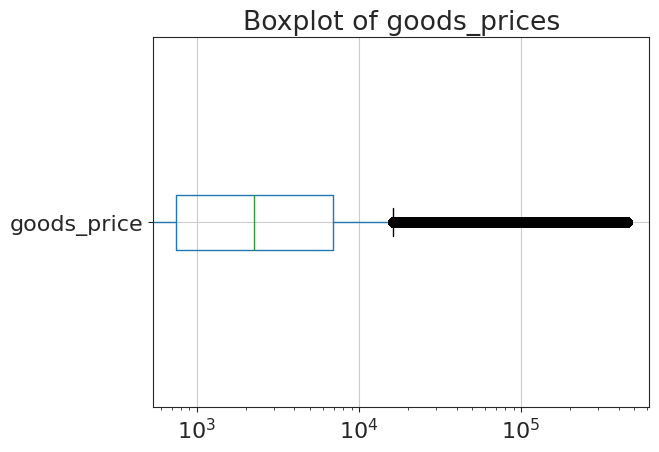

In [76]:
# plot at boxplot
train[['goods_price']].boxplot(vert = False)
plt.title('Boxplot of goods_prices')
plt.xscale('log')

# look at quantiles of values
train[['goods_price']].quantile([.005, .98, .99, .9998]).transpose()

### Conclusion on Data Preprocessing


After the initial data preprocessing, the following aspects were investigated:

1. No encoding is required for data types, as all features are numerical.
2. Outliers and rare values were assessed.

3. Missing values in feature 2 were imputed with the median value for the corresponding goods category. After imputation, the characteristics of the data distribution remained unchanged.

4. Data types in the features "goods_price" and "offer_price" were converted to the same integer type.

## Embeddings

We have been provided with embeddings for textual descriptions and images of products. The method used to obtain these embeddings is unknown.

- `goods_image_vectors`
  - `embed_deperson.npy`: Vectors for images.
  - `items_deperson.npy`: Vectors identified by product identifiers for the assortment of goods.

- `offer_image_vectors`
  - `embed_deperson.npy`: Vectors for images.
  - `items_deperson.npy`: Vectors identified by product identifiers for the offered goods.

## Goods embeddings

### Goods image

In [ ]:
# embeddings for goods on market
goods_image_path = '/kaggle/input/samokat-tech/goods_image_vectors/goods_image_vectors/embed_deperson.npy'

# their id
goods_id_path = '/kaggle/input/samokat-tech/goods_image_vectors/goods_image_vectors/items_deperson.npy'

In [ ]:
# load  and open the embeddings
goods_image_vector = np.load(goods_image_path)
goods_id_vector = np.load(goods_id_path)

print(f'''
Image vector size: {goods_image_vector.shape}

Identifier vector size: {goods_id_vector.shape}''')

The sizes match

In [ ]:
# NumPy array with embeddings
embedding_matrix = goods_image_vector

# Specify the percentage of explained variance we want to retain
explained_variance_percentage = 99

# Create a PCA object and reduce dimensionality
pca = PCA(n_components=explained_variance_percentage / 100, svd_solver='full')
reduced_good_img = pca.fit_transform(goods_image_vector)

print("Original dimensionality:", embedding_matrix.shape[1])
print()
print("Reduced dimensionality:", reduced_good_img.shape[1])
print()
print("Explained variance:", np.sum(pca.explained_variance_ratio_))

In [ ]:
# asses values in the goods_id_vector
goods_id_vector[:35]

In [ ]:
# make int from str
goods_id_vector_int = list(map(int, goods_id_vector))

In [ ]:
goods_image_vector.shape[1]

To make it more convenient to work with the data, let's generate feature names for each embedding

In [ ]:
# generate columns names
goods_image_names = []
for col in range(reduced_good_img.shape[1]):
    goods_image_names.append('goods_img_' + str(col))

In [ ]:
# create a df og image embeddings
goods_img = pd.DataFrame(reduced_good_img, columns = goods_image_names)
goods_img['goods_depersanalised'] = goods_id_vector_int
goods_img.head()

In [ ]:
# access the presence of the image embedings id in data
train[train['goods_depersanalised'].isin(goods_id_vector_int)]['goods_depersanalised'].nunique()

In [ ]:
train.shape

There is no embedding for each entry in the image data, which may be due to the specificity of the object. We should look at another embedding.

## Goods title

- `goods_title_vectors` for assortment goods
  - `embed_deperson.npy`: Vectors of titles + attributes.
  - `items_deperson.npy`: Identifiers.

- `offer_title_vectors` for offered goods
  - `embed_deperson.npy`: Vectors of titles + attributes.
  - `items_deperson.npy`: Identifiers.

In [ ]:
# embeddings for goods title on market
goods_title_path = '/kaggle/input/samokat-tech/goods_title_vectors/goods_title_vectors/embed_deperson.npy'
# their id
goods_id_title_path = '/kaggle/input/samokat-tech/goods_title_vectors/goods_title_vectors/items_deperson.npy'


In [ ]:
# load  and open the embeddings
goods_title_vector = np.load(goods_title_path)
goods_id_title_vector = np.load(goods_id_title_path)

print(f'''
Size of embeddings with attributes: {goods_title_vector.shape}

Size of embeddings with id for attributes: {goods_id_title_vector.shape}''')

In [ ]:
goods_id_title_vector[:15]

In [ ]:
# change type
goods_id_title_int = list(map(int, goods_id_title_vector))

In [ ]:
# access the presence of the title embedings id in data
train[train['goods_depersanalised'].isin(goods_id_title_int)]['goods_depersanalised'].nunique()

All entries in data have its own embedding

In [ ]:
# NumPy array with embeddings
embedding_matrix = goods_title_vector

# percentage of explained variance wewant to retain
explained_variance_percentage = 99
# reducing dimensionality
pca = PCA(n_components=explained_variance_percentage / 100, svd_solver='full')
reduced_goods_title = pca.fit_transform(goods_title_vector)

# Print the results
print("Original dimensionality:", embedding_matrix.shape[1])
print()
print("Reduced dimensionality:", reduced_goods_title.shape[1])
print()
print("Explained variance:", np.sum(pca.explained_variance_ratio_))

In [ ]:
# generate columns names
goods_title_names = []
for col in range(reduced_goods_title.shape[1]):
    goods_title_names.append('goods_tit_' + str(col))

In [ ]:
# have a look at resulting df with goods titles
goods_title = pd.DataFrame(reduced_goods_title, columns = goods_title_names )
goods_title['goods_depersanalised'] = goods_id_title_int
goods_title.head()

# Offers embedding

## Offers image

In [ ]:
# embeddings for goods on market
offer_image_path = '/kaggle/input/samokat-tech/offer_image_vectors/offer_image_vectors/embed_deperson.npy'
# their id
offer_id_image_path = '/kaggle/input/samokat-tech/offer_image_vectors/offer_image_vectors/items_deperson.npy'

In [ ]:
# load  and open the embeddings
offer_image_vector = np.load(offer_image_path)
offer_id_image_vector = np.load(offer_id_image_path)

print(f'''
Size of embeddings with images of offers: {offer_image_vector .shape}

Size of embeddings with id for images of offers: {offer_id_image_vector.shape}''')

In [ ]:
# change type
offers_id_image_int = list(map(int, offer_id_image_vector))

In [ ]:
train['offer_depersanalised'].nunique()

In [ ]:
# asess the presence of the title embedings id in the data
train[train['offer_depersanalised'].isin(offers_id_image_int)]['offer_depersanalised'].nunique()

In [ ]:
# NumPy array with embeddings
embedding_matrix = offer_image_vector

# percentage of explained variance we want to retain
explained_variance_percentage = 99

#  reduce dimensionality
pca = PCA(n_components = explained_variance_percentage / 100, svd_solver = 'full')
reduced_offer_image_vector = pca.fit_transform(offer_image_vector)

# Print the results
print("Original dimensionality:", embedding_matrix.shape[1])
print()
print("Reduced dimensionality:", reduced_offer_image_vector.shape[1])
print()
print("Explained variance:", np.sum(pca.explained_variance_ratio_))


In [ ]:
# generate columns names
offers_image_names = []
for col in range(reduced_offer_image_vector.shape[1]):
    offers_image_names.append('offers_img_' + str(col))

In [ ]:
offers_img = pd.DataFrame(data = reduced_offer_image_vector,
                          columns = offers_image_names)

offers_img['offer_depersanalised'] = offers_id_image_int
offers_img.head()

## Offers title

In [ ]:
# embeddings for goods on market
offer_title_path = '/kaggle/input/samokat-tech/offer_title_vectors/offer_title_vectors/embed_deperson.npy'
# their id
offer_id_title_path = '/kaggle/input/samokat-tech/offer_title_vectors/offer_title_vectors/items_deperson.npy'

In [ ]:
# load  and open the embeddings
offer_title_vector = np.load(offer_title_path)
offer_id_title_vector = np.load(offer_id_title_path)

print(f'''
Size of embeddings with attributes of offers: {offer_title_vector.shape}

Size of embeddings with id for attributes of offers: {offer_id_title_vector.shape}''')

In [ ]:
# change type
offer_id_title_int = list(map(int, offer_id_title_vector))

In [ ]:
#  array of embeddings
embedding_matrix = offer_title_vector

#  the percentage of explained variance 
explained_variance_percentage = 99

#  reduce dimensionality
pca = PCA(n_components = explained_variance_percentage / 100, svd_solver = 'full')
reduced_offer_title_vector = pca.fit_transform(offer_title_vector)

# Print the results
print("Original dimensionality:", embedding_matrix.shape[1])
print()
print("Reduced dimensionality:", reduced_offer_title_vector.shape[1])
print()
print("Explained variance:", np.sum(pca.explained_variance_ratio_))


In [ ]:
# generate columns names
offers_title_names = []
for col in range(reduced_offer_title_vector.shape[1]):
    offers_title_names.append('offers_tit_' + str(col))

In [ ]:
# df with titles of offers
offer_title = pd.DataFrame(data = reduced_offer_title_vector,
                           columns = offers_title_names)
offer_title['offer_depersanalised'] = offer_id_title_int
offer_title.head()

**Create a new feature based on distances between vectors. 
For this, I will create two vectors (image vectors for goods and corresponding vectors for offers). 
Then, I will create a vector of distances with a length corresponding to the number of objects in the vectors. 
This procedure is resource-intensive, so I saved the resulting vectors and loaded them later on the platform. 
The code is available in markdown.**

> a = train_with_img[offers_image_names].fillna(0.0)
> b = train_with_img[goods_image_names].fillna(0.0)
> print(f'''{a.shape}, {b.shape}''')

> > result = np.zeros([1, 1])
> > for i in tqdm(list(a.index)):
> >     dist = pairwise_distances(np.array(a.iloc[i]).reshape(1, -1), 
> >                               np.array(b.iloc[i]).reshape(1, -1), 
> >                               metric = 'sqeuclidean')
> >     result = np.concatenate((result, dist))
> >     
> >     if i % 1000000 == 0:
> >         print(result.shape)
>         
> np.save('train_dist', result)

a = train_with_title[offers_title_names].fillna(0.0)
b = train_with_title[goods_title_names].fillna(0.0)
print(f'''{a.shape}, {b.shape}''')

result = np.zeros([1, 1])
for i in tqdm(list(a.index)):
    dist = pairwise_distances(np.array(a.iloc[i]).reshape(1, -1), 
                              np.array(b.iloc[i]).reshape(1, -1), 
                              metric = 'sqeuclidean')
    result = np.concatenate((result, dist))
    
    if i % 1000000 == 0:
        print(result.shape)
        
np.save('train_title_dist', result)

In [ ]:
gc.collect()

In [ ]:
# add distanses between title's vectors to a dataframe
train['title_dist'] = np.load('/kaggle/input/train-title/train_title_dist.npy')[1:]
# vector distance between images
train['img_dist'] = np.load('/kaggle/input/train-distances/train_dist.npy')[1:]

In [ ]:
# access the presence of the title embedings id in data
train[train['offer_depersanalised'].isin(offer_id_title_int)]['offer_depersanalised'].nunique()

In [ ]:
# add embeddings to the data
train_with_title = pd.merge(train, goods_title.drop_duplicates('goods_depersanalised'),
                        on = 'goods_depersanalised',
                        how = 'left')

train_with_title = pd.merge(train_with_title, offer_title.drop_duplicates('offer_depersanalised'),
                        on = 'offer_depersanalised',
                        how = 'left')

train_with_title.shape

In [ ]:
# add embeddings to the data
train_all = pd.merge(train_with_title, goods_img.drop_duplicates('goods_depersanalised'),
                          on = 'goods_depersanalised',
                          how = 'left')

train_all = pd.merge(train_all, offers_img.drop_duplicates('offer_depersanalised'),
                          on = 'offer_depersanalised',
                          how = 'left')
train_all.shape

In [ ]:
# look at a resulting data
train_all.shape

In [ ]:
# check missing values after joining
pass_value_barh(train_all)

In [ ]:
# fill all with 0
train_all.fillna(0, inplace = True)

In [ ]:
pass_value_barh(train_all)

After adding embeddings, our data has the following characteristics: 
- 1,996,670 rows
- 627 features 

# Preprocess test data

I will process the test data similarly to the training data:

- Fill missing goods_category_id with category -5.
- Fill missing values in goods_price with the median value for the corresponding goods category.
- Replace category 2463684633817211.0 with 10.
- Examine the distribution to understand what to do with outliers.
- convert 'offer_price', 'goods_price' into int format

In [ ]:
test_data['id'].duplicated().sum()

In [ ]:
# asses missing values
pass_value_barh(test_data)

In [ ]:
test_data['goods_category_id'] = test_data['goods_category_id'].fillna(-5)

In [ ]:
# replace cat which inconvinient with value 10
test_data.loc[test_data['goods_category_id'] == 2463684633817211.0, 'goods_category_id'] = 10

In [ ]:
# mapping the missing goods_price values based on their corresponding goods_category_id
# to the previously calculated median values
goods_price_filled = test_data.loc[test_data['goods_price'].isna(), 'goods_category_id'] \
                                                .map(median_price_map)
goods_price_filled.sample(10)

In [ ]:
# replace entries with NaNs with the median value
test_data.loc[test_data['goods_price'].isna(), 'goods_price'] = goods_price_filled
# check
pass_value_barh(test_data['goods_price'])

In [ ]:
test_data[['offer_price', 'goods_price']] = test_data[['offer_price', 'goods_price']].astype('int')

In [ ]:
test_data[['goods_price']].quantile([.005, .98, .99, .9998])

The distribution of values in the 'goods_price' feature is identical to the training set, which means we can process them identically

In [ ]:
test_data.shape

In [ ]:
# Add corresponding features with distance vectors for objects in the test set.
test_data['title_dist'] = np.load('/kaggle/input/test-title-distance/test_title_dist.npy')[1:]
test_data['img_dist'] = np.load('/kaggle/input/test-distances/test_dist.npy')[1:]

In [ ]:
# join embeddings
test = pd.merge(test_data, goods_title.drop_duplicates('goods_depersanalised'),
                        on = 'goods_depersanalised',
                        how = 'left')

test = pd.merge(test, offer_title.drop_duplicates('offer_depersanalised'),
                        on = 'offer_depersanalised',
                        how = 'left')

test = pd.merge(test, goods_img.drop_duplicates('goods_depersanalised'),
                          on = 'goods_depersanalised',
                          how = 'left')

test = pd.merge(test, offers_img.drop_duplicates('offer_depersanalised'),
                          on = 'offer_depersanalised',
                          how = 'left')
test.shape

In [ ]:
test.fillna(0, inplace = True)

The resulting dataframe retained the original number of rows

# Machine learning

In [ ]:
# find a categorical features
train.select_dtypes(include = 'object')

In [ ]:
train.columns

In [ ]:
train_all['target'].mean()

The sample is unbalanced, but we cannot balance it since we do not know the class balance in the test set. If we train on a balanced sample, the model may make significant errors. Therefore, for now, we leave it as is

In [ ]:
# split the 
train_idx, valid_idx = train_test_split(train_all.index,
                                shuffle = True,
                                test_size = 0.25,
                                random_state = SEED)
print(f'''
Training set size: {train_idx.shape}

Validation set size: {valid_idx.shape}
''')

I dont need scaling because i am going to use onle tree based algorithms

In [ ]:
# clean garbage variables
gc.collect()

Divide the dataset into batches to optimize resource usage

In [ ]:
# Set the batch size
batch_size = 500000  

# Get the number of batches
num_batches = len(train_idx) // batch_size + int(len(train_idx) % batch_size > 0)

for i in tqdm(range(0,num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)
    print(start_idx, end_idx)

### Baseline on a data without embeddings

Get the baseline without embeddings only with distances and original feature

In [ ]:
train_dist = train_all[train.columns].drop(index = valid_idx.to_list())
valid_dist = train_all[train.columns].drop(index = train_idx.to_list())
train_dist.shape

In [ ]:
# Separate the training and target features
X = train_dist.drop(['target', 'id'], axis = 1).columns.to_list()
y = 'target'

In [ ]:
# fit
params = {'learning_rate' : 0.06,
          'eval_metric' : 'F1',
          'task_type' : 'GPU',
          'verbose' : 100,
          'random_seed' : SEED}

In [ ]:
catboost = CatBoostClassifier(**params)

# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_dist) else len(train_dist)
    # Create a batch Pool
    batch_pool = Pool(data = train_dist.iloc[start_idx : end_idx][X],
                      label = train_dist.iloc[start_idx : end_idx][y])
    
    catboost.fit(batch_pool, eval_set = None)
    # clean garbage variables
    gc.collect()

In [ ]:
# assess the result based on data without embeddings
y_score = catboost.predict_proba(valid_dist[X])[:,1]

In [ ]:
# Find the best threshold
res = []

for thr in tqdm(np.linspace(0, 1, 101)):
    res.append((thr, f1_score(valid_dist[y].astype('int'), y_score > thr)))

df_f1 = pd.DataFrame(res, columns=['thr', 'f1'])
df_f1.sort_values('f1', ascending=False)

# Visualize the result
df_f1.set_index('thr').plot()
plt.title('F1 for Various Thresholds')
plt.show()

In [ ]:
df_f1.sort_values('f1', ascending = False)

In [ ]:
# clean garbage variables
gc.collect()

## Light GBM

In [ ]:
!pip install lightgbm -q
import lightgbm as lgb

In [ ]:
params = {
    'objective': 'binary',
    'verbosity': -1,
    'device': 'gpu',
    'learning_rate': 0.06}

# Pass parameters
lgbm = lgb.LGBMClassifier(**params)

# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_dist) else len(train_dist)

    # training set
    train_dist.iloc[start_idx : end_idx][X],
    train_dist.iloc[start_idx : end_idx][y]
    
    lgbm.fit(train_dist.iloc[start_idx : end_idx][X], 
             train_dist.iloc[start_idx : end_idx][y])

In [ ]:
valid_dist['y_score'] = lgbm.predict_proba(valid_dist[X])[:,1]

In [ ]:
# find the best threshold
res = []

for thr in tqdm(np.linspace(0,1,101)):
    res.append((thr, f1_score(valid_dist[y].astype('int'), valid_dist['y_score'] > thr)))

In [ ]:
df_f1 = pd.DataFrame(res,columns = ['thr','f1'])
df_f1.sort_values('f1',ascending = False)

In [ ]:
# Visualize the result
df_f1.set_index('thr').plot()
plt.title('f1 for various thresholds')
plt.show()

## Hyperparameters tuning

In [ ]:
# Create parameters grid for optimization search
def objective(trial):

    params = {
    'eval_metric': 'F1',
    'learning_rate' : trial.suggest_float('learning_rate', 0.015, 0.15),
    'l2_leaf_reg' : trial.suggest_int('l2_leaf_reg', 1, 9),
    'task_type' : 'GPU',
    'verbose' : 100
    }

    catboost = CatBoostClassifier(**params)
    
    # Loop over batches
    for i in tqdm(range(num_batches)):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)

        # Create a batch Pool
        batch_pool = Pool(data = train_dist.iloc[start_idx : end_idx][X],
                      label = train_dist.iloc[start_idx : end_idx][y])
    
        catboost.fit(batch_pool, eval_set = None)
        gc.collect()
    
    predictions = catboost.predict(valid_dist[X])
    score = f1_score(valid_dist[y], predictions)    

    return score


In [ ]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

In [ ]:
best_params

In [ ]:
params = { 'eval_metric': 'F1', 'learning_rate' : 0.14195152908399983, 'l2_leaf_reg' : 6, 'task_type' : 'GPU', 'verbose' : 100 }

In [ ]:
catboost = CatBoostClassifier(**params)
    
# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_dist) else len(train_dist)

    # Create a batch Pool
    batch_pool = Pool(data = train_dist.iloc[start_idx : end_idx][X],
                      label = train_dist.iloc[start_idx : end_idx][y])
    
    catboost.fit(batch_pool, eval_set = None)
    gc.collect()


In [ ]:
valid_dist['y_score'] = catboost.predict_proba(valid_dist[X])[:,1]
# find the best threshold
res = []

for thr in tqdm(np.linspace(0,1,101)):
    res.append((thr,f1_score(valid_dist[y].astype('int'), valid_dist['y_score'] > thr)))


In [ ]:
df_f1 = pd.DataFrame(res,columns = ['thr','f1'])
df_f1.sort_values('f1',ascending = False)


In [ ]:
# Visualize the result

df_f1.set_index('thr').plot()
plt.title('f1 for various thresholds')
plt.show()

In [ ]:
# Find the best threshold
best_thr_idx = df_f1.sort_values('f1', ascending = False)['thr'].head(1).index
thr = float(df_f1.iloc[best_thr_idx]['thr'])
thr

In [ ]:
# Analyze feature importance
# Train a model to extract feature importance

catboost_feature_importance = catboost.get_feature_importance(prettified=True)
catboost_feature_importance.columns = ['Features','Importances']
# Plot the graph
sns.barplot(catboost_feature_importance.sort_values(by='Importances', ascending=False).head(20), x='Importances', y='Features')
plt.title("CatBoost's Feature Importance")
plt.show()


We see that image embeddings provide more hints for our model, so let's add them and see the result.

In [ ]:
# Delete variables to free up resources
del train_dist
del valid_dist

## With image embeddings

The outcome is just fine, so I added image vectors to see the result with those features

In [ ]:
img_columns = train.columns.to_list() + offers_image_names + goods_image_names 
tit_columns = train.columns.to_list() + offers_title_names + goods_title_names 

In [ ]:
train_img = train_all[img_columns].drop(index = valid_idx)
valid_img = train_all[img_columns].drop(index = train_idx)
train_img.shape

In [ ]:
pass_value_barh(train_img)

In [ ]:
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)
    print(start_idx, end_idx)
    

In [ ]:
X = train_img.drop(['target', 'id'], axis = 1).columns.to_list()

In [ ]:
# fit
params = {'learning_rate' : 0.06,
          'eval_metric' : 'F1',
          'task_type' : 'GPU',
          'verbose' : 100,
          'random_seed' : SEED}
    
catboost = CatBoostClassifier(**params)

# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)
    # Create a batch Pool
    batch_pool = Pool(data = train_img.iloc[start_idx : end_idx][X],
                      label = train_img.iloc[start_idx : end_idx][y])
    
    catboost.fit(batch_pool, eval_set = None)
    # clean garbage variables
    gc.collect()

add all embeddings to see the result

In [ ]:
# Analyze feature importance
# Train a model to extract feature importance

catboost_feature_importance = catboost.get_feature_importance(prettified=True)
catboost_feature_importance.columns = ['Features','Importances']
# Plot the graph
sns.barplot(catboost_feature_importance.sort_values(by='Importances', ascending=False).head(20), x='Importances', y='Features')
plt.title("CatBoost's Feature Importance")
plt.show()


In [ ]:
valid_img['y_score'] = catboost.predict_proba(valid_img[X])[:,1]
# find the best threshold
res = []

for thr in tqdm(np.linspace(0,1,101)):
    res.append((thr,f1_score(valid_img[y].astype('int'), valid_img['y_score'] > thr)))
df_f1 = pd.DataFrame(res,columns = ['thr','f1'])

# Visualize the result
df_f1.set_index('thr').plot()
plt.title('f1 for various thresholds')
plt.show()

In [ ]:
df_f1.sort_values('f1',ascending = False)

In [ ]:
# Delete variables to free up resources
del train_img
del valid_img

## With all embeddings

In [ ]:
# create a data wich includes all embeddings 
train_all_emb = train_all.drop(index = valid_idx)
valid_all_emb = train_all.drop(index = train_idx)
train_all_emb.shape

In [ ]:
# features
X = train_all_emb.drop(['target', 'id'], axis = 1).columns.to_list()

In [ ]:
gc.collect()

In [ ]:
# fit
params = {'learning_rate' : 0.06,
          'eval_metric' : 'F1',
          'task_type' : 'GPU',
          'verbose' : 100,
          'random_seed' : SEED}
    
catboost = CatBoostClassifier(**params)

# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)
    # Create a batch Pool
    batch_pool = Pool(data = train_all_emb.iloc[start_idx : end_idx][X],
                      label = train_all_emb.iloc[start_idx : end_idx][y])
    
    catboost.fit(batch_pool, eval_set = None)
    # clean garbage variables
    gc.collect()

In [ ]:
valid_all_emb['y_score'] = catboost.predict_proba(valid_all_emb[X])[:,1]
# find the best threshold
res = []

for thr in tqdm(np.linspace(0,1,101)):
    res.append((thr,f1_score(valid_all_emb[y].astype('int'), valid_all_emb['y_score'] > thr)))
    df_f1 = pd.DataFrame(res,columns = ['thr','f1'])

    
# Visualize the result
df_f1.set_index('thr').plot()
plt.title('f1 for various thresholds')
plt.show()

In [ ]:
df_f1.sort_values('f1',ascending = False)

In [ ]:
gc.collect()

In [ ]:
# Analyze feature importance
# Train a model to extract feature importance

catboost_feature_importance = catboost.get_feature_importance(prettified=True)
catboost_feature_importance.columns = ['Features','Importances']
# Plot the graph
sns.barplot(catboost_feature_importance.sort_values(by='Importances', ascending=False).head(20), x='Importances', y='Features')
plt.title("CatBoost's Feature Importance")
plt.show()


In [ ]:
# Create parameter's  grid for optimization search

def objective(trial):

    params = {
    'eval_metric': 'F1',
    'learning_rate' : trial.suggest_float('learning_rate', 0.015, 0.15),
    'l2_leaf_reg' : trial.suggest_int('l2_leaf_reg', 1, 9),
    'task_type' : 'GPU',
    'verbose' : 100
    }

    catboost = CatBoostClassifier(**params)
    
    # Loop over batches
    for i in tqdm(range(num_batches)):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)

        # Create a batch Pool
        batch_pool = Pool(data = train_all_emb.iloc[start_idx : end_idx][X],
                      label = train_all_emb.iloc[start_idx : end_idx][y])
    
        catboost.fit(batch_pool, eval_set = None)
        gc.collect()
    
    predictions = catboost.predict(valid_all_emb[X])
    score = f1_score(valid_all_emb[y], predictions)    

    return score
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 25)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

In [ ]:
best_params

In [ ]:
best_params = { 'eval_metric': 'F1', 
               'learning_rate' : 0.09278986198955744, 
               'l2_leaf_reg' : 4, 
               'task_type' : 'GPU',
               'verbose' : 100,
               'random_seed' : SEED}

In [ ]:
# train on the whole data
catboost = CatBoostClassifier(**best_params)
# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)
    
    # Create a batch Pool
    batch_pool = Pool(data = train_all_emb.iloc[start_idx : end_idx][X],
                      label = train_all_emb.iloc[start_idx : end_idx][y])
    
    catboost.fit(batch_pool, eval_set = None)
    gc.collect()

In [ ]:
# find the best thr
valid_all_emb['y_score'] = catboost.predict_proba(valid_all_emb[X])[:,1]# find the best threshold
res = []

for thr in tqdm(np.linspace(0,1,101)):
    res.append((thr,f1_score(valid_all_emb[y].astype('int'), valid_all_emb['y_score'] > thr)))
    df_f1 = pd.DataFrame(res,columns = ['thr','f1'])


# Visualize the result
df_f1.set_index('thr').plot()
plt.title('f1 for various thresholds')
plt.show()

In [ ]:
df_f1.sort_values('f1',ascending = False)

In [ ]:
best_thr_idx = df_f1.sort_values('f1', ascending = False)['thr'].head(1).index
thr = float(df_f1.iloc[best_thr_idx]['thr'])
thr

In [ ]:
# Set the batch size
batch_size = 500000  

# Get the number of batches
num_batches = len(train_all) // batch_size + int(len(train_all) % batch_size > 0)

for i in tqdm(range(0,num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_all) else len(train_all)
    print(start_idx, end_idx)

In [ ]:
# train on the whole data
catboost = CatBoostClassifier(**best_params)
# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_all) else len(train_all)
    
    # Create a batch Pool
    batch_pool = Pool(data = train_all.iloc[start_idx : end_idx][X],
                      label = train_all.iloc[start_idx : end_idx][y])
    
    catboost.fit(batch_pool, eval_set = None)
    gc.collect()

## Submission

In [ ]:
# make preds on test
prediction = catboost.predict_proba(test[X])

In [ ]:
y_test = (prediction > thr).astype('int')[:,1]
y_test

In [ ]:
y_test.mean()

In [ ]:
submit_example = pd.read_csv('/kaggle/input/samokat-tech/sample_submission.csv')
submit_example.columns

In [ ]:
submit = submit_example
submit['target'] = y_test
submit.to_csv('submit_last.csv', index=False)

In [ ]:
submit

In [ ]:
from sklearn import neighbors
n_neighbors = 20
 #

knn_model = neighbors.KNeighborsClassifier(n_neighbors,
                                          weights = 'distance',
                                          metric = 'cosine')

In [ ]:
X = train_all.drop(['target', 'id'], axis = 1).columns.to_list()
y = 'target'

In [ ]:
y_pred = np.zeros([1])
y_pred.shape

In [ ]:
# Set the batch size
batch_size = 500000  

# Get the number of batches
num_batches = len(train_idx) // batch_size + int(len(train_idx) % batch_size > 0)

for i in tqdm(range(0,num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)
    knn_model.fit(train_all.drop(index = valid_idx).iloc[start_idx:end_idx][X], 
                  train_all.drop(index = valid_idx).iloc[start_idx:end_idx][y])
 

In [ ]:
# Get the number of batches
num_batches = len(valid_idx) // batch_size + int(len(valid_idx) % batch_size > 0)

for i in tqdm(range(0, num_batches)):
    
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(valid_idx) else len(valid_idx)
    prediction = knn_model.predict_proba(train_all.drop(index = train_idx).iloc[start_idx:end_idx][X])[:,1]
    y_pred = np.concatenate((y_pred, prediction))

In [ ]:
res = []

for thr in tqdm(np.linspace(0,1,101)):
    res.append((thr,f1_score(train_all.drop(index = train_idx)[y].astype('int'), 
                             y_pred[1:] > thr)))
    
    df_f1 = pd.DataFrame(res,columns = ['thr','f1'])

# Visualize the result
df_f1.set_index('thr').plot()
plt.title('f1 for various thresholds')
plt.show()

In [ ]:
f1_score(train_all.drop(index = train_idx)[y].astype('int'), 
         y_pred[1:]>0.2)

In [ ]:
valid_idx.shape